In [3]:
import sympy as sym

def cubic_spline_clamped(xs: list[float],
                         ys: list[float],
                         B0: float,
                         B1: float
                        ) -> list[sym.Expr]:
    """
    Interpolación por splines cúbicos condicionados (clamped).
    
    Parámetros:
    - xs, ys: listas de abscisas y ordenadas de los puntos (no tienen que estar ordenadas).
    - B0: pendiente deseada en x0, es decir S'(x0) = B0.
    - B1: pendiente deseada en xn, es decir S'(xn) = B1.
    
    Devuelve:
    - Lista de n polinomios sympy S_j(x) que interpolan en los intervalos [x_j, x_{j+1}].
    """
    # 1) Ordenar los puntos por la coordenada x
    puntos = sorted(zip(xs, ys), key=lambda p: p[0])
    xs = [p[0] for p in puntos]
    ys = [p[1] for p in puntos]
    n = len(xs) - 1
    
    # 2) Calcular longitudes de intervalos h_i
    h = [xs[i+1] - xs[i] for i in range(n)]
    
    # 3) Construir el vector alpha con las condiciones en los extremos
    alpha = [0.0]*(n+1)
    # extremo izquierdo (clamped en B0):
    alpha[0] = 3*(ys[1] - ys[0]) / h[0] - 3*B0
    # interior:
    for i in range(1, n):
        alpha[i] = (3/h[i])*(ys[i+1] - ys[i]) \
                 - (3/h[i-1])*(ys[i] - ys[i-1])
    # extremo derecho (clamped en B1):
    alpha[n] = 3*B1 - 3*(ys[n] - ys[n-1]) / h[n-1]
    
    # 4) Thomas (descomposición tridiagonal)
    l = [1.0]
    mu = [0.0]
    z = [0.0]
    for i in range(1, n):
        li = 2*(xs[i+1] - xs[i-1]) - h[i-1]*mu[i-1]
        l.append(li)
        mu.append(h[i] / li)
        zi = (alpha[i] - h[i-1]*z[i-1]) / li
        z.append(zi)
    l.append(1.0)
    z.append(0.0)
    
    # 5) Back-substitution para c_j
    c = [0.0]*(n+1)
    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
    
    # 6) Calcular a, b, d y construir S_j(x)
    x = sym.Symbol('x')
    splines = []
    for j in range(n):
        a = ys[j]
        b = (ys[j+1] - ys[j]) / h[j] \
            - (h[j]/3)*(2*c[j] + c[j+1])
        d = (c[j+1] - c[j]) / (3*h[j])
        # Polinomio simbólico:
        Sj = sym.simplify(
            a
            + b*(x - xs[j])
            + c[j]*(x - xs[j])**2
            + d*(x - xs[j])**3
        )
        splines.append(Sj)
    
    return splines

In [4]:
xs = [0, 1, 2]
ys = [1, 5, 3]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

-1.5*x**3 + 5.5*x + 1

1.5*x**3 - 9.0*x**2 + 14.5*x - 2.0

______


-1.5*x**3 + 5.5*x + 1

1.5*x**3 - 9.0*x**2 + 14.5*x - 2.0

In [5]:
xs = [0, 1, 2]
ys = [-5, -4, 3]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1.5*x**3 - 0.5*x - 5

-1.5*x**3 + 9.0*x**2 - 9.5*x - 2.0

______


1.5*x**3 - 0.5*x - 5

-1.5*x**3 + 9.0*x**2 - 9.5*x - 2.0

In [6]:
xs = [0, 1, 2,3]
ys = [1, 1, 5,2]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1.53333333333333*x**3 - 1.53333333333333*x + 1

-3.66666666666667*x**3 + 15.6*x**2 - 17.1333333333333*x + 6.2

2.13333333333333*x**3 - 19.2*x**2 + 52.4666666666667*x - 40.2

______


1.53333333333333*x**3 - 1.53333333333333*x + 1

-3.66666666666667*x**3 + 15.6*x**2 - 17.1333333333333*x + 6.2

2.13333333333333*x**3 - 19.2*x**2 + 52.4666666666667*x - 40.2

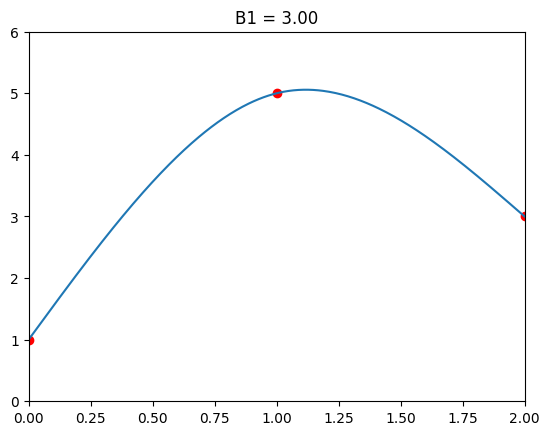

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 1) Definimos la función spline cúbico clamped
def cubic_spline_clamped(xs, ys, B0, B1):
    puntos = sorted(zip(xs, ys), key=lambda p: p[0])
    xs = [p[0] for p in puntos]
    ys = [p[1] for p in puntos]
    n = len(xs) - 1
    h = [xs[i+1] - xs[i] for i in range(n)]
    alpha = [0.0]*(n+1)
    alpha[0] = 3*(ys[1] - ys[0]) / h[0] - 3*B0
    for i in range(1, n):
        alpha[i] = (3/h[i])*(ys[i+1] - ys[i]) - (3/h[i-1])*(ys[i] - ys[i-1])
    alpha[n] = 3*B1 - 3*(ys[n] - ys[n-1]) / h[n-1]

    l = [1.0]
    mu = [0.0]
    z = [0.0]
    for i in range(1, n):
        li = 2*(xs[i+1] - xs[i-1]) - h[i-1]*mu[i-1]
        l.append(li)
        mu.append(h[i] / li)
        z.append((alpha[i] - h[i-1]*z[i-1]) / li)
    l.append(1.0)
    z.append(0.0)

    c = [0.0]*(n+1)
    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]

    x = sp.symbols('x')
    splines = []
    for j in range(n):
        a = ys[j]
        b = (ys[j+1] - ys[j]) / h[j] - (h[j]/3)*(2*c[j] + c[j+1])
        d = (c[j+1] - c[j]) / (3*h[j])
        Sj = a + b*(x - xs[j]) + c[j]*(x - xs[j])**2 + d*(x - xs[j])**3
        splines.append(sp.lambdify(x, Sj, 'numpy'))
    return splines

# 2) Datos de ejemplo
xs = [0, 1, 2]
ys = [1, 5, 3]

B0 = 1.0

# 3) Preparamos la figura y artistas
fig, ax = plt.subplots()
x_vals = np.linspace(xs[0], xs[-1], 400)
line, = ax.plot([], [])
scatter = ax.scatter(xs, ys, color="red")

def init():
    ax.set_xlim(xs[0], xs[-1])
    ax.set_ylim(min(ys) - 1, max(ys) + 1)
    line.set_data([], [])
    # Fijamos de nuevo los puntos
    scatter.set_offsets(np.c_[xs, ys])
    return line, scatter

def update(B1):
    funcs = cubic_spline_clamped(xs, ys, B0, B1)
    y_vals = np.piecewise(
        x_vals,
        [(x_vals >= xs[i]) & (x_vals <= xs[i+1]) for i in range(len(xs)-1)],
        funcs
    )
    line.set_data(x_vals, y_vals)
    ax.set_title(f"B1 = {B1:.2f}")
    return line, scatter

# 4) Creamos y mostramos la animación
B1_values = np.linspace(-3, 3, 61)
anim = FuncAnimation(
    fig, update, frames=B1_values,
    init_func=init, blit=True, interval=200
)
HTML(anim.to_jshtml())
